what to do?
so when the models have different resolution we could do 2 things:
take highest resolution and for lower res ones take the value of nearest "pixel" for each one (this gives us high res results but lower resolution models will have high errors does not really work for them)
take lowest res and calculate the average of nearby "pixels"(maybe even by their overlap) for each large pixel this will work but only give us low res results

maybe do it individually for each model (so we can use that models res) to get a higher res lowest res estimate. (but that might be difficult and also makes it harder to compare models)

In [2]:
import xarray as xr
import intake
from collections import defaultdict
import matplotlib.pyplot as plt
import xesmf
import numpy as np

wind : v -south-north

u: west-east

In [7]:
path_full = "lehre/msc-intro-computational-meteorology-exercises-w2025/ERA5/ERA5_monthly.1940-2025.t2m_wind10_pres.nc"
path_1deg = "lehre/msc-intro-computational-meteorology-exercises-w2025/ERA5/ERA5_monthly.1940-2025.t2m_wind10_pres.1deg.nc"
data = xr.open_dataset(path_full)
data_1deg = xr.open_dataset(path_1deg)

In [8]:
data_wind = data

In [9]:
def lat_lon_sel(data,lat_bnds,lon_bnds,attributes):
    lat_vals = data[attributes[0]][attributes[1]].values
    long_vals = data[attributes[0]][attributes[2]].values

    lat_vals = lat_vals[lat_vals>lat_bnds[0]]
    lat_vals = lat_vals[lat_vals<lat_bnds[1]]

    long_vals = long_vals[long_vals>lon_bnds[0]]
    long_vals = long_vals[long_vals<lon_bnds[1]]
    return lat_vals,long_vals


In [20]:
lat_boundary = [-32,-14]
long_boundary = [360-78,360-62]
attributes = ["t2m","latitude","longitude"]
lat_vals,long_vals = lat_lon_sel(data_wind,lat_boundary,long_boundary,attributes)

In [19]:
atts1deg = ["t2m","lat","lon"]
lat_vals_1deg,long_vals_1deg = lat_lon_sel(data_1deg,lat_boundary,long_boundary,atts1deg)

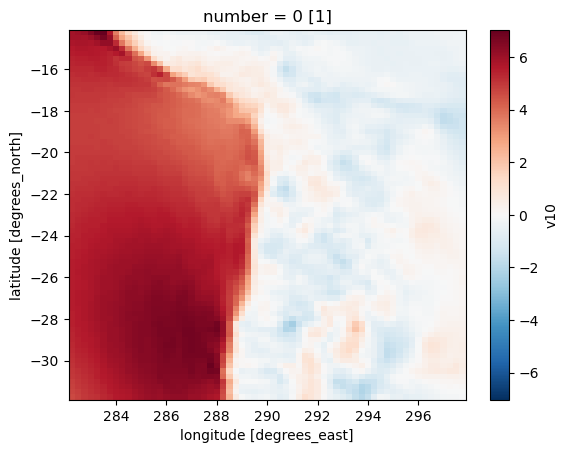

In [12]:
data_wind["v10"].sel({"latitude":lat_vals,"longitude":long_vals}).mean("valid_time").plot()

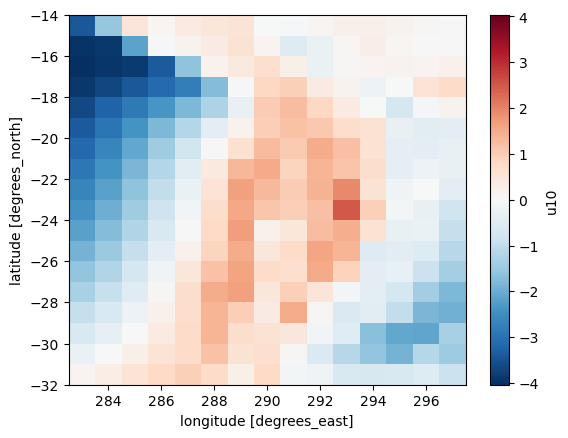

In [32]:
data_wind.sel({"lat":lat_vals,"lon":long_vals}).mean("valid_time")["u10"].plot()

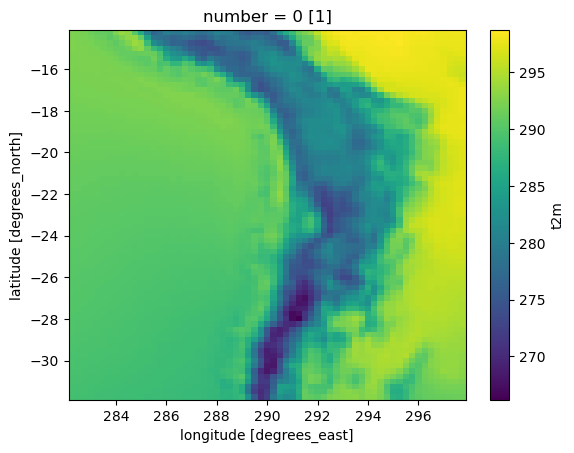

In [34]:
data_wind["t2m"].sel({"latitude":lat_vals,"longitude":long_vals}).mean("valid_time").plot()

CIMP6 data

In [13]:
cat = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
query = dict(
    variable_id=['tas'],
    table_id='Amon',
    experiment_id=['historical'],
    grid_label='gn',
    member_id='r1i1p1f1'
)

cat_subset = cat.search(require_all_on=["source_id"], **query)
dsets = cat_subset.to_dataset_dict(
    zarr_kwargs={'consolidated': True},
    storage_options={'token': 'anon'}
)
list(dsets)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


['CMIP.CCCR-IITM.IITM-ESM.historical.Amon.gn',
 'CMIP.NCC.NorESM2-MM.historical.Amon.gn',
 'CMIP.AWI.AWI-ESM-1-1-LR.historical.Amon.gn',
 'CMIP.MIROC.MIROC6.historical.Amon.gn',
 'CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn',
 'CMIP.AWI.AWI-CM-1-1-MR.historical.Amon.gn',
 'CMIP.MRI.MRI-ESM2-0.historical.Amon.gn',
 'CMIP.MPI-M.MPI-ESM1-2-HR.historical.Amon.gn',
 'CMIP.AS-RCEC.TaiESM1.historical.Amon.gn',
 'CMIP.NCC.NorCPM1.historical.Amon.gn',
 'CMIP.BCC.BCC-ESM1.historical.Amon.gn',
 'CMIP.UA.MCM-UA-1-0.historical.Amon.gn',
 'CMIP.CMCC.CMCC-CM2-HR4.historical.Amon.gn',
 'CMIP.CAS.FGOALS-g3.historical.Amon.gn',
 'CMIP.CAMS.CAMS-CSM1-0.historical.Amon.gn',
 'CMIP.SNU.SAM0-UNICON.historical.Amon.gn',
 'CMIP.CCCma.CanESM5.historical.Amon.gn',
 'CMIP.CMCC.CMCC-ESM2.historical.Amon.gn',
 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Amon.gn',
 'CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.Amon.gn',
 'CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn',
 'CMIP.NASA-GISS.GISS-E2-2-H.historical.Amon.gn',
 'CMIP.NCAR

In [183]:
dsiter = iter(dsets)

n = 2
current_model = next(dsiter)
#current_model = next(dsiter)
curr_ds = dsets[current_model]
curr_ds = curr_ds.sortby("time")

atts_cmip = ["tas","lat","lon"]
lat_vals_cmip,lon_vals_cmip = lat_lon_sel(curr_ds,lat_boundary,long_boundary,atts_cmip)

In [184]:
start_date = "1980-01-01"
end_date   = "2005-12-31"
Era5_1deg_red = data_1deg["t2m"].sel({"lat":lat_vals_1deg,"lon":long_vals_1deg}).rename({"valid_time":"time"}).sel({"time":slice(start_date,end_date)})
Cmip_data_red = curr_ds["tas"].sel({"lat":lat_vals_cmip,"lon":lon_vals_cmip}).sel({"time":slice(start_date,end_date)})

regrid_cmip_to_era5 = xesmf.Regridder(Cmip_data_red, Era5_1deg_red, method='conservative', periodic=True)


/opt/conda/lib/python3.10/site-packages/xesmf/frontend.py:95: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  lon_bnds = ds.cf.get_bounds('longitude')


In [185]:
start_date = "1940-01-01"
end_date   = "2026-12-31"
#Cmip_data_red = Cmip_data_red.sel({"time":slice(start_date,end_date)})
tas = regrid_cmip_to_era5(Cmip_data_red)

In [192]:
b = Era5_1deg_red.resample(time="1ME").nearest()
a = tas.resample(time="1ME").nearest()
a["time"] = a.time.astype("datetime64[ns]")

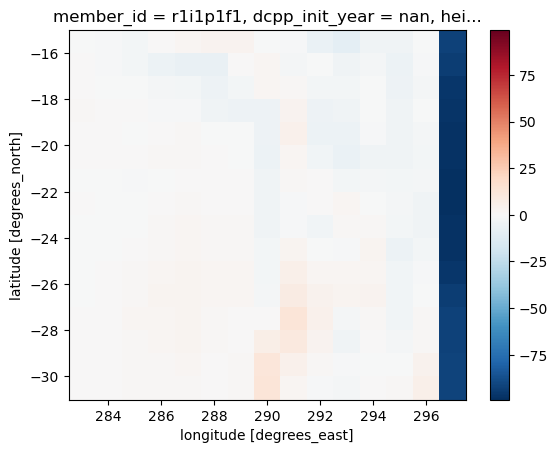

In [188]:
(a-b).sel({"time":a.time.values[0]}).plot()

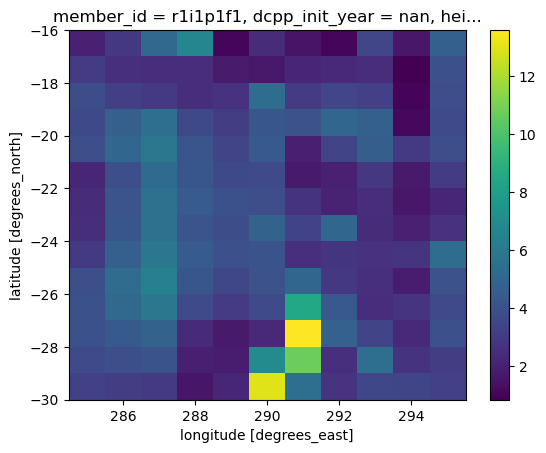

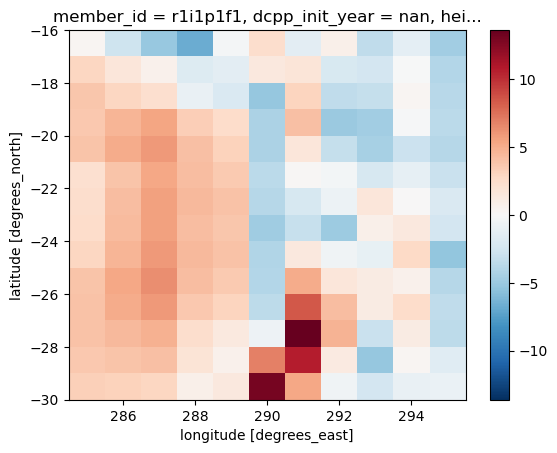

In [197]:
cutoff = 2.1
lat_boundary_adj = [lat_boundary[0]+cutoff,lat_boundary[1]-cutoff]#[-32,-14]
long_boundary_adj =  [long_boundary[0]+cutoff,long_boundary[1]-cutoff]#[360-78,360-62]
atts1deg = ["t2m","lat","lon"]

#lat_vals_1deg,long_vals_1deg = lat_lon_sel(data_1deg,lat_boundary_adj,long_boundary_adj,atts1deg)

a = a.sel({"lat":slice(lat_boundary_adj[0],lat_boundary_adj[1]),"lon":slice(long_boundary_adj[0],long_boundary_adj[1])})
b = b.sel({"lat":slice(lat_boundary_adj[0],lat_boundary_adj[1]),"lon":slice(long_boundary_adj[0],long_boundary_adj[1])})
(abs(a-b)).mean("time").plot()
plt.figure()
((a-b)).mean("time").plot()

/opt/conda/lib/python3.10/site-packages/xesmf/frontend.py:95: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  lon_bnds = ds.cf.get_bounds('longitude')
/opt/conda/lib/python3.10/site-packages/xesmf/frontend.py:95: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  lon_bnds = ds.cf.get_bounds('longitude')
/opt/conda/lib/python3.10/site-packages/xesmf/frontend.py:95: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  lon_bnds = ds.cf.get_bounds('longitude')
/opt/conda/lib/python3.10/site-packages/xesmf/frontend.py:95: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  lon_bnds = ds.cf.get_bounds('longitude')


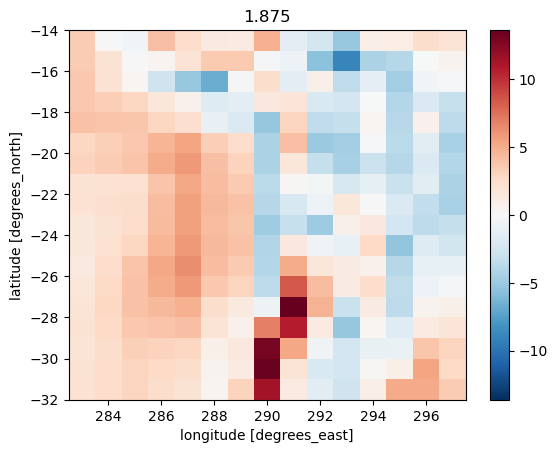

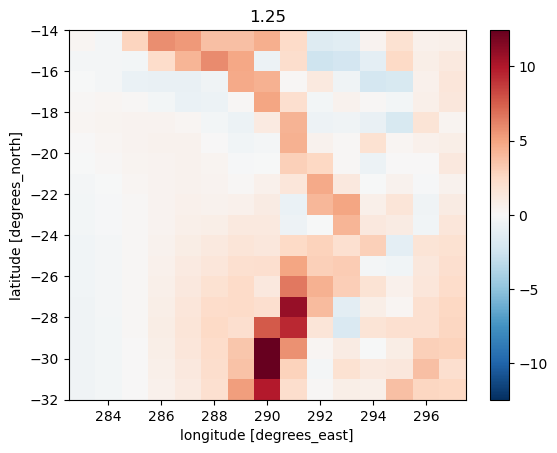

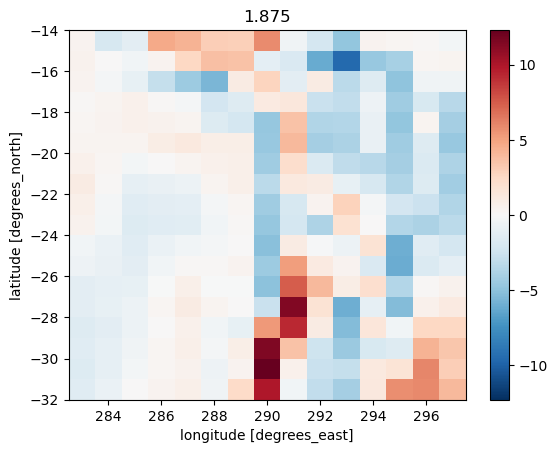

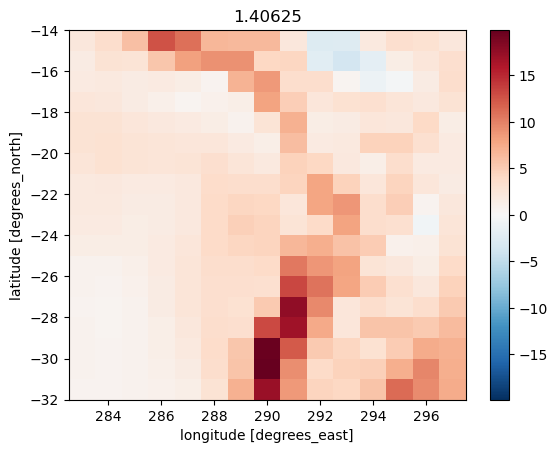

In [208]:

lat_boundary = [-40,-10]#[-32,-14]
long_boundary =[360-85,360-55] #[360-78,360-62]

dsiter = iter(dsets)
n = 4
start_date = "1980-01-01"
end_date   = "2005-12-31"
Era5_1deg_red = data_1deg["t2m"].sel({"lat":lat_vals_1deg,"lon":long_vals_1deg}).rename({"valid_time":"time"}).sel({"time":slice(start_date,end_date)})
b = Era5_1deg_red.resample(time="1ME").nearest()
for i in range(n):#36
    current_model = next(dsiter)
    curr_ds = dsets[current_model]
    curr_ds = curr_ds.sortby("time")

    
    #datasets use different variable names for their spacial data we want to average over
    if "lat" in dsets[current_model].coords:
        #CMIP_mean_temps = curr_ds["tas"].mean(dim=['lat', 'lon']).resample(time="YE").mean().values.ravel()
        

        Cmip_data_red = curr_ds["tas"].sel({"lat":slice(lat_boundary[0],lat_boundary[1]),"lon":slice(long_boundary[0],long_boundary[1]),"time":slice(start_date,end_date)})

        regrid_cmip_to_era5 = xesmf.Regridder(Cmip_data_red, Era5_1deg_red, method='conservative', periodic=True)
        tas = regrid_cmip_to_era5(Cmip_data_red)
        b = Era5_1deg_red.resample(time="1ME").nearest()
        a = tas.resample(time="1ME").nearest()
        a["time"] = a.time.astype("datetime64[ns]")

        cutoff = Cmip_data_red.lon.values[1]-Cmip_data_red.lon.values[0]
        lat_boundary_adj = [lat_boundary[0]+cutoff,lat_boundary[1]-cutoff]#[-32,-14]
        long_boundary_adj =  [long_boundary[0]+cutoff,long_boundary[1]-cutoff]#[360-78,360-62]
        atts1deg = ["t2m","lat","lon"]

        #lat_vals_1deg,long_vals_1deg = lat_lon_sel(data_1deg,lat_boundary_adj,long_boundary_adj,atts1deg)

        a = a.sel({"lat":slice(lat_boundary_adj[0],lat_boundary_adj[1]),"lon":slice(long_boundary_adj[0],long_boundary_adj[1])})
        b = b.sel({"lat":slice(lat_boundary_adj[0],lat_boundary_adj[1]),"lon":slice(long_boundary_adj[0],long_boundary_adj[1])})
        plt.figure()
        (a-b).mean("time").plot()
        plt.title(str(cutoff))

    elif "i" in dsets[current_model].coords:
        continue
        #CMIP_mean_temps = curr_ds["tas"].mean("i").resample(time="YE").mean().values.ravel()
    else:
        continue
        #CMIP_mean_temps = curr_ds["tas"].mean(dim=['latitude', 'longitude']).resample(time="YE").mean().values.ravel()


In [ ]:
a["lat"] = np.round(a["lat"],3)

In [117]:
xr.align(a,b,join="exact")

AlignmentError: cannot align objects with join='exact' where index/labels/sizes are not equal along these coordinates (dimensions): 'lat' ('lat',)

In [ ]:
a["tas"]-

ValueError: Cannot apply_along_axis when any iteration dimensions are 0

In [127]:
b

<xarray.DataArray 't2m' (time: 312, lat: 18, lon: 15)> Size: 337kB
[84240 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2kB 1980-01-31 1980-02-29 ... 2005-12-31
  * lon      (lon) float64 120B 283.0 284.0 285.0 286.0 ... 295.0 296.0 297.0
  * lat      (lat) float64 144B -31.5 -30.5 -29.5 -28.5 ... -16.5 -15.5 -14.5
Attributes: (12/32)
    standard_name:                            unknown
    long_name:                                2 metre temperature
    units:                                    K
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    ...                                       ...
    GRIB_missingValue:                        3.4028234663852886e+38
    GRIB_name:                                2 metre temperature
    GRIB_shortName:                           2t
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    GRIB_surface:                             0.0

In [126]:
a-b

ValueError: operands cannot be broadcast together with mismatched lengths for dimension 'lat': (18, 1)

In [ ]:
b = Era5_1deg_red.resample(time="1ME").nearest()
a = tas.resample(time="1ME").nearest()

In [157]:
start_date = "1940-01-01"
end_date   = "2026-12-31"
Cmip_data_red = Cmip_data_red.sel({"time":slice(start_date,end_date)})

In [ ]:
Era5_1deg_red = Era5_1deg_red.rename({"valid_time":"time"})

<xarray.DataArray 't2m' (time: 1029, lat: 18, lon: 15)> Size: 1MB
array([[[291.12967, 290.796  , ..., 295.21332, 297.01138],
        [291.37836, 291.088  , ..., 295.33615, 298.3649 ],
        ...,
        [295.5605 , 294.7138 , ..., 297.7653 , 297.0717 ],
        [294.58423, 294.2419 , ..., 298.0763 , 297.58682]],

       [[291.6396 , 291.36896, ..., 294.36063, 296.64194],
        [291.86478, 291.6621 , ..., 294.7192 , 298.30035],
        ...,
        [296.0291 , 295.05768, ..., 298.34692, 297.61664],
        [294.9568 , 294.66965, ..., 298.31348, 297.78445]],

       ...,

       [[287.43652, 287.12943, ..., 285.27982, 286.7193 ],
        [287.79053, 287.42444, ..., 286.2792 , 288.02875],
        ...,
        [289.09262, 289.02676, ..., 297.39566, 296.95874],
        [289.15018, 289.0092 , ..., 298.0303 , 297.6286 ]],

       [[287.42096, 287.15823, ..., 288.68478, 289.99408],
        [287.66452, 287.39795, ..., 289.7112 , 291.66672],
        ...,
        [289.41052, 289.10977, ..., 301.05444, 300.6013 ],
        [289.2459 , 289.3728 , ..., 301.0942 , 300.76733]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 8kB 1940-01-01 1940-02-01 ... 2025-09-01
  * lon      (lon) float64 120B 283.0 284.0 285.0 286.0 ... 295.0 296.0 297.0
  * lat      (lat) float64 144B -31.5 -30.5 -29.5 -28.5 ... -16.5 -15.5 -14.5
Attributes: (12/32)
    standard_name:                            unknown
    long_name:                                2 metre temperature
    units:                                    K
    GRIB_paramId:                             167
    GRIB_dataType:                            an
    GRIB_numberOfPoints:                      1038240
    ...                                       ...
    GRIB_missingValue:                        3.4028234663852886e+38
    GRIB_name:                                2 metre temperature
    GRIB_shortName:                           2t
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    GRIB_surface:                             0.0

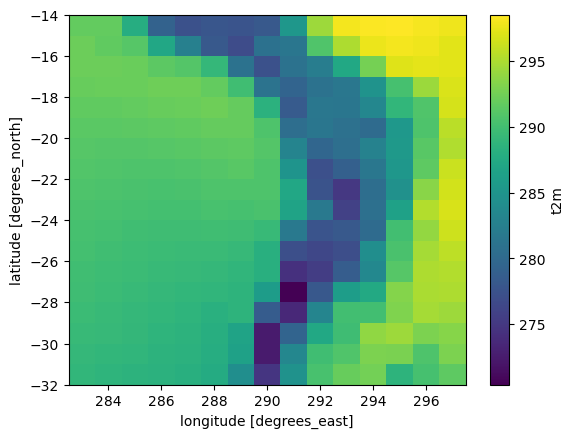

In [139]:
(Era5_1deg_red).mean("valid_time").plot()

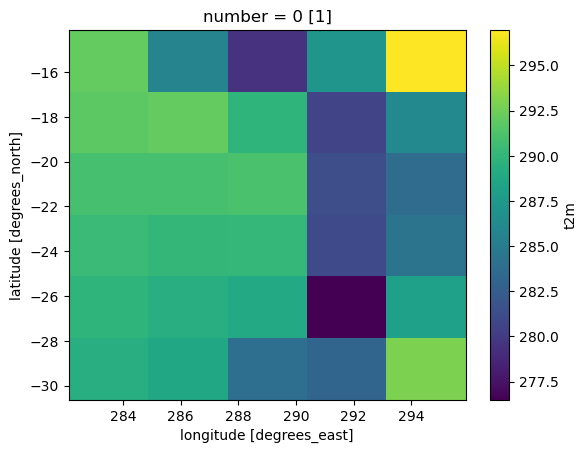

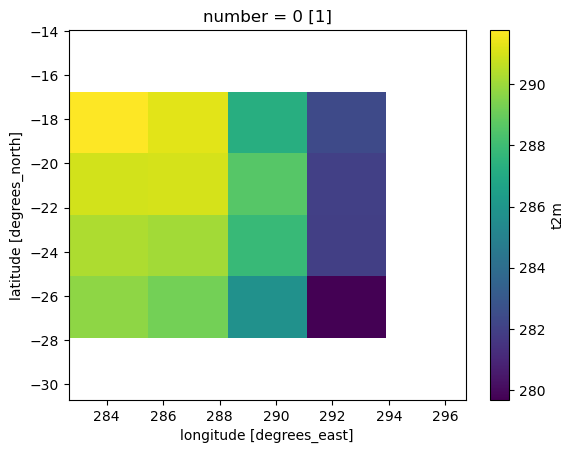

In [106]:
factor=11
Era5_coarse = Era5.coarsen(latitude=factor,longitude=factor,boundary="trim").mean()
Era5_int = Era5_coarse.interp(latitude=d_lat_vals,longitude=d_long_vals,method="linear")
Era5_coarse.plot()
plt.figure()
Era5_int.plot()

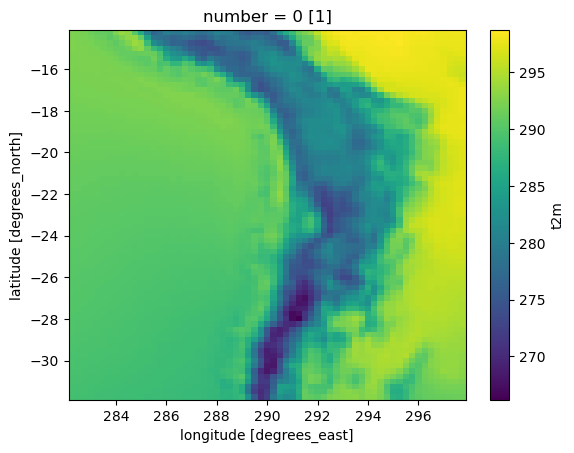

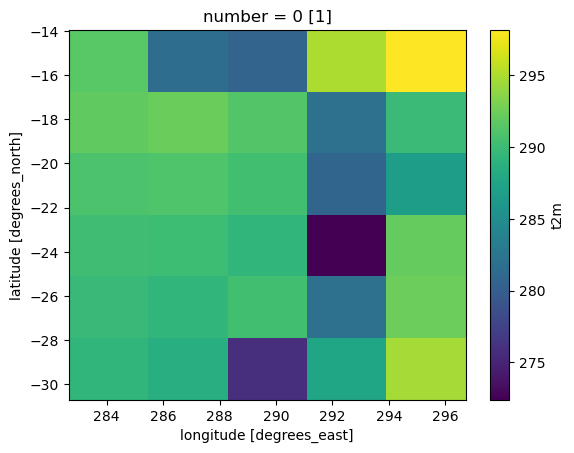

In [69]:
#plt.subplots(1,2)
Era5.plot()
plt.figure()
Era5.interp(latitude=d_lat_vals,longitude=d_long_vals,method="linear").plot()


In [48]:
b = a.mean("time")

In [ ]:
(data_wind["t2m"].sel({"latitude":lat_vals,"longitude":long_vals}).mean("valid_time")-b["tas"])

SyntaxError: invalid syntax (2115443340.py, line 1)

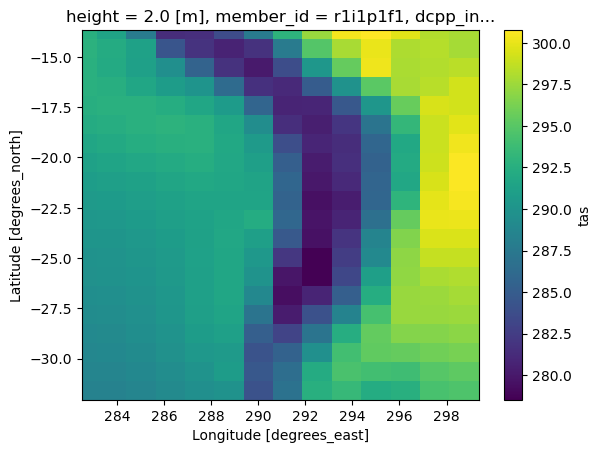

In [38]:
b["tas"].plot()

In [57]:
dsiter = iter(dsets)

n = 36
lattice = []
for i in range(n):#36
    current_model = next(dsiter)
    curr_ds = dsets[current_model]
    try:
        d_lat_vals = curr_ds["tas"]["lat"].values
        lattice.append((d_lat_vals[1]-d_lat_vals[0]))
    except:
        pass

In [61]:
lattice

[0.9424083769633569,
 0.9424083769633569,
 1.8947368421052602,
 0.9424083769633569,
 0.9424083769633569,
 0.9424083769633569,
 1.8887829660363167,
 0.9424083769633569,
 2.0,
 5.181141717273036,
 0.9424083769633569,
 2.7672718509152645,
 2.0,
 1.25,
 1.3890301392687405,
 1.1120905585095784,
 1.8947368421052602,
 1.8496375593391292,
 1.849639892578125,
 0.9424083769633569,
 2.7672718509152787,
 1.8496375593391292,
 1.25,
 0.9272240138487149,
 2.0,
 1.8947368421052602,
 2.0,
 1.4173202514648438,
 1.8947368421052602,
 0.9272240138487007,
 1.112089999999995,
 1.1120905585095784,
 0.9424083769633569,
 1.8496375593391292]

In [60]:
np.min(lattice)

0.9272240138487007

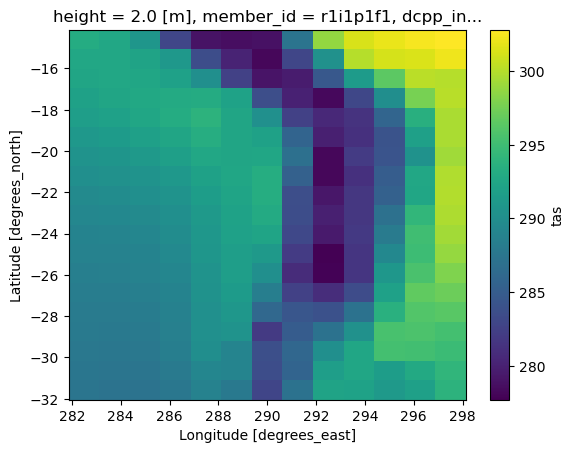

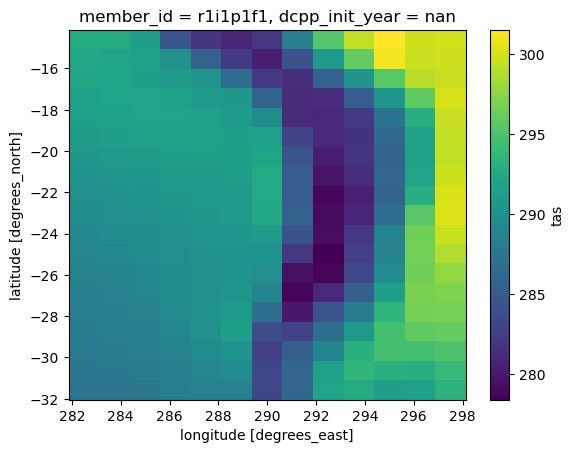

In [ ]:
lat_boundary = [-32,-14]
long_boundary = [360-78,360-62]




dsiter = iter(dsets)

n = 2
times_mean = np.arange(1850,2024,1)         #timesstamps for model mean
model_mean = np.zeros(times_mean.size)      #variable for the mean of the model
model_mean_diff = np.zeros(times_mean.size) #variable for mean anomaly
meancount = np.zeros(times_mean.size)       #count of how many models contribute to the mean(at borders only like 2 models contribute so we cannot divide by n)
maxsize = 0
model_temps = []
for i in range(n):#36
    current_model = next(dsiter)
    curr_ds = dsets[current_model]
    curr_ds = curr_ds.sortby("time")

    #datasets use different variable names for their spacial data we want to average over
    if "lat" in dsets[current_model].coords:
        #CMIP_mean_temps = curr_ds["tas"].mean(dim=['lat', 'lon']).resample(time="YE").mean().values.ravel()
        
        d_lat_vals = curr_ds["tas"]["lat"].values
        d_long_vals = curr_ds["tas"]["lon"].values
        d_lat_vals = d_lat_vals[d_lat_vals>lat_boundary[0]]
        d_lat_vals = d_lat_vals[d_lat_vals<lat_boundary[1]]

        d_long_vals = d_long_vals[d_long_vals>long_boundary[0]]
        d_long_vals = d_long_vals[d_long_vals<long_boundary[1]]
        plt.figure()
        curr_ds["tas"].sel({"lat":d_lat_vals,"lon":d_long_vals}).mean("time").plot()

    elif "i" in dsets[current_model].coords:
        continue
        #CMIP_mean_temps = curr_ds["tas"].mean("i").resample(time="YE").mean().values.ravel()
    else:
        continue
        #CMIP_mean_temps = curr_ds["tas"].mean(dim=['latitude', 'longitude']).resample(time="YE").mean().values.ravel()
    """
    m1850_1900 = CMIP_mean_temps[:50].mean()

    times = curr_ds.resample(time="YE").mean()["time"].values.astype('datetime64[Y]')
    label = str.join("-",current_model.split(".")[1:3])

    #calculate the effect on mean of models
    if CMIP_mean_temps.size>maxsize:
        maxsize=CMIP_mean_temps.size
        mtimes=times
    meancount[:CMIP_mean_temps.size]+=1
    model_mean[:CMIP_mean_temps.size] +=+CMIP_mean_temps
    model_mean_diff[:CMIP_mean_temps.size] +=+CMIP_mean_temps-m1850_1900

    model_temps.append([times,CMIP_mean_temps,m1850_1900,label])

times_mean = times_mean[:maxsize]
model_mean = model_mean[:maxsize]/meancount[:maxsize]
model_mean_diff = model_mean_diff[:maxsize]/meancount[:maxsize]
mmm1850_1900 = model_mean[:50].mean()
"""